# Script that explores a method to look of a subset of images maximizing the representational dissimilarity (in terms of RSA) between several models.

### AIM:
We would like to select 50 images that maximizes the representational dissimilarity between 2 models, say the ViT14 trained on SAYCam VS EGO4D. In this case, representational dissimilarity is the dissimilarity between the RDMs of the 2 models for the given 50 images. We also would like these images to be visually/semantically interpretable (i.e. we are not interested in just noise). We start from 2 medium-size datasets with a semantically wide variety of categories - the validation sets of ImageNet and EcoSet. They include 1000 and 565 different categories respectively, with 50 different images within each category, for a total of 50000 and 28250 images.

### CHALLENGE:
It is computationally unthinkable to look at every possible combinations of 50 images within the 25K+ images - they follow a binomial distribution. Instead, we need a different, more creative approach.

### IDEA:
Presumably, the set of 50 images should be such that, when model A finds some images very similar model B should find them very dissimilar, and vice-versa.
Presumably again, images that one model may find very similar are likely within the same category (at least when it comes to the last layers of the models). We could thus find the image categories for which modelA has a stable representation (images within the category lead to similar representations) while modelB has an unstable representation.

We introduce the concept of *representational compactness*. The representational compactness of a concept determines how well a concept is represented disctinctly from other in the latent space of a model. We will say that **car** is well delineated when car images are represented similarly with respect to other images i.e the vectors of activations for car images form a cluster in latent space.


In [1]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from torchvision.ops.misc import interpolate
from tqdm.notebook import tqdm as tqdm_notebook

#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *
from scipy.spatial import procrustes as scipro

from lib.algos_maxRSA import find_max_dissimilarity_images

importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [29]:
dataset = 'ecoVal'
#models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random', 'resnet']
models  = ['ego', 'saycam']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

(28250, 768)

In [30]:
#### Normalize vectors
for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    activations[model] = activations[model]/norms # normalization

In [2]:
#### Compute RDMs performing squared euclidean distance as a metric (to be equivalent to CKA methods, cf. Williams, 2024)
RDMs = {}

metric = 'L2squared'
for i, model in enumerate(models):
    print(model)
    RDMs[model] = rsa.compute_RDMs(activations[model], metric = metric, display = False, title = f'{model}_{metric}')
    RDMs[model] = cka.centering(RDMs[model])




NameError: name 'models' is not defined

In [37]:
RDMs[model].shape

(28250, 28250)

In [33]:
### Compute similarities between models and metrics.
sim_metric = 'pearson'

SIMs = {} # save all similarity values in a dictionary

for i, model1 in enumerate(models[:-1]):
    SIMs[model1] = {}
    for j, model2 in enumerate(models[i+1:]):
        SIMs[model1][model2] = float(np.round(rsa.Compute_sim_RDMs(RDMs[model1], RDMs[model2], center = False, metric = sim_metric), 3))

#SIMs_saycam_ego = np.float64(0.6297048936065802) # already computed
SIMs

{'ego': {'saycam': 0.649}}

In [34]:
### check if images were shown in the same order
assert imagelists['ego'] == imagelists['saycam']
imagelist = imagelists['ego'] # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate


#np.array(imagelist).reshape(-1, nb_per_cat)[0]

In [35]:
nb_per_cat

50

We introduce here the concept of *representational compactness* - *representational compactness* measures how much a given concept (e.g objet category) is well defined in a laten space relative to other concepts. More precisely, if a concept (say a car) is compact, then the latent representations images of the same concept (e.g. images of cars) are very similar (i.e. similar vecotrs of representations) relative to other concepts (e.g. bananas or house).

In [36]:
### Compute representational compactness for each category and model
compactness = {}
compact_categories = {}
for model in models:
    print(model)
    compactness_tmp = np.zeros(len(listcat))
    RDM = RDMs[model]
    for c, cat in enumerate(listcat):
        cat_RDM = RDM[c*nb_per_cat:(c+1)*nb_per_cat, c*nb_per_cat:(c+1)*nb_per_cat] # square matrix of nb_cat x nb_cat
        noncat_RDM = np.concatenate([RDM[c*nb_per_cat:(c+1)*nb_per_cat, :c*nb_per_cat], RDM[c*nb_per_cat:(c+1)*nb_per_cat, (c+1)*nb_per_cat:]], axis =1) # Rectangular matrix of nb_cat x (n-nb_cat)
        upper_indices = np.triu_indices(nb_per_cat, k=1)  # k=1 excludes diagonal
        sim_withincat = np.mean(cat_RDM[upper_indices]) # Compute similarity within the category
        sim_withoutcat = np.mean(noncat_RDM) # Compute similarity with other categories
        compactness_tmp[c] = sim_withincat/sim_withoutcat # compactness is the ratio between within similarity and without similarity
    compactness[model] = np.sort(compactness_tmp)
    compact_categories[model] = np.array(listcat)[np.argsort(compactness_tmp)]




ego
saycam


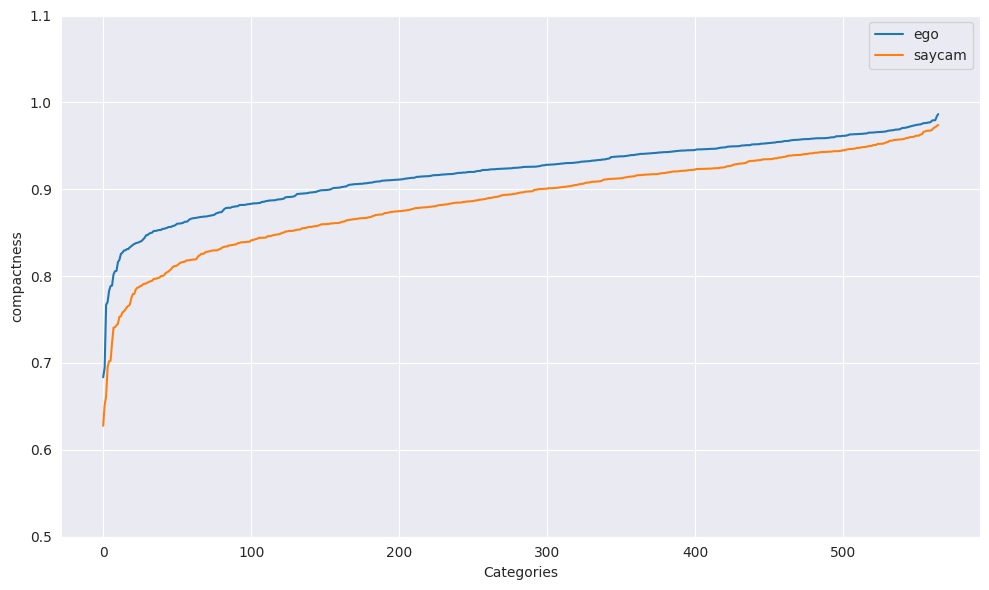

ego
['1073_fireworks' '0156_moon' '0266_gravel' '0812_coin' '2144_newsstand'
 '0089_bus' '1515_waterspout' '2098_odometer' '2112_photocopier'
 '0005_house' '2400_geyser' '0082_kitchen' '0437_drawers' '1933_flashbulb'
 '0847_jaguar' '1081_thermostat' '0909_flea' '1043_mall' '2972_rainbow'
 '1367_sphinx']
saycam
['0266_gravel' '0156_moon' '1073_fireworks' '0089_bus' '2144_newsstand'
 '2212_manhole' '0005_house' '0082_kitchen' '1515_waterspout'
 '2098_odometer' '0812_coin' '0882_scoreboard' '0772_barnacle' '0909_flea'
 '1043_mall' '2972_rainbow' '0969_anthill' '2400_geyser' '1612_forklift'
 '0009_car']
ego
['1125_cork' '2205_dildo' '1010_barrel' '0875_broom' '0359_shovel'
 '0533_seashell' '2783_bubble' '0312_dustpan' '0052_fish' '1470_syringe'
 '0111_doll' '0112_bell' '0877_ladle' '1026_condom' '0045_ball'
 '1635_paintbrush' '0767_padlock' '0187_umbrella' '0361_bucket'
 '0223_vase']
saycam
['1026_condom' '0311_crawfish' '1379_chalice' '0389_ashtray' '0955_cane'
 '2332_cogwheel' '0052_fish

In [38]:
max_rsa.plot_stats_one(compactness, models,  ['Categories', 'compactness'])
for model in models:
    print(f'{model}')
    print(compact_categories[model][:20])
for model in models:
    print(f'{model}')
    print(compact_categories[model][-20:])

In [39]:
def check_list_similarity(list1, list2):
    '''Checks if two lists contain the same elements, regardless of order,
    and calculates the proportion of common elements.'''
    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1 & set2  # Intersection of sets
    proportion = (len(common_elements) / max(len(set1), len(set2))) * 100 if max(len(set1), len(set2)) > 0 else 0
    return proportion

print('\nSimilarities saycam and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories['saycam'][:50],compact_categories[model][:50]))

print('\nSimilarities ego and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories['ego'][:50],compact_categories[model][:50]))
'''
print('\nSimilarities imagenet and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories['imagenet'][:50],compact_categories[model][:50]))

print('\nSimilarities supervised and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories['supervised'][:50],compact_categories[model][:50]))

print('\nSimilarities resnet and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories['resnet'][:50],compact_categories[model][:50]))'''


Similarities saycam and the others
76.0
100.0

Similarities ego and the others
100.0
76.0


"\nprint('\nSimilarities imagenet and the others')\nfor model in models[:]:\n    print(check_list_similarity(compact_categories['imagenet'][:50],compact_categories[model][:50]))\n\nprint('\nSimilarities supervised and the others')\nfor model in models[:]:\n    print(check_list_similarity(compact_categories['supervised'][:50],compact_categories[model][:50]))\n\nprint('\nSimilarities resnet and the others')\nfor model in models[:]:\n    print(check_list_similarity(compact_categories['resnet'][:50],compact_categories[model][:50]))"

In [40]:
### Compute 500 random sequence for significance
# initialize sequences
nb_trials = 500
idx_vec = np.array(range(len(listcat)))
mat_vec = np.zeros((nb_trials, len(idx_vec)))
for i in range(nb_trials):
    np.random.shuffle(idx_vec)
    mat_vec[i] = idx_vec

#Compute all possible similarity pairs
list_sim = []
for i in range(len(mat_vec)-1):
    for j in range(i+1,len(mat_vec)):
        list_sim.append(check_list_similarity(list(mat_vec[i][:50]), list(mat_vec[j][:50])))

# Compute 95 percentile
confinter = np.percentile(list_sim, 95)
print(f'The 95% confidence interval is:{confinter}')

The 95% confidence interval is:16.0


In [41]:
### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    shape = activations[model].shape
    cat_activations[model] = activations[model].reshape(-1, nb_per_cat, shape[-1])

In [13]:
#def compute_silhouette_score_memory_efficient(cat_activations, models, listcat, metric='euclidean'):
'''compactness2, compact_categories2 = max_rsa.categorical_silhouette_score(cat_activations, models, listcat, metric='sqeuclidean')
max_rsa.plot_stats(compactness2,models,  ['Categories', 'Normalized var'])
for model in models:
    print(f'{model}')
    print(compact_categories2[model][:20])
for model in models:
    print(compact_categories2[model][-20:])


print('\nSimilarities saycam and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories2['saycam'][:50],compact_categories2[model][:50]))

print('\nSimilarities ego and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories2['ego'][:50],compact_categories2[model][:50]))

print('\nSimilarities imagenet and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories2['imagenet'][:50],compact_categories2[model][:50]))

print('\nSimilarities supervised and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories2['supervised'][:50],compact_categories2[model][:50]))

print('\nSimilarities resnet and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories2['resnet'][:50],compact_categories2[model][:50]))'''

"compactness2, compact_categories2 = max_rsa.categorical_silhouette_score(cat_activations, models, listcat, metric='sqeuclidean')\nmax_rsa.plot_stats(compactness2,models,  ['Categories', 'Normalized var'])\nfor model in models:\n    print(f'{model}')\n    print(compact_categories2[model][:20])\nfor model in models:\n    print(compact_categories2[model][-20:])\n\n\nprint('\nSimilarities saycam and the others')\nfor model in models[:]:\n    print(check_list_similarity(compact_categories2['saycam'][:50],compact_categories2[model][:50]))\n\nprint('\nSimilarities ego and the others')\nfor model in models[:]:\n    print(check_list_similarity(compact_categories2['ego'][:50],compact_categories2[model][:50]))\n\nprint('\nSimilarities imagenet and the others')\nfor model in models[:]:\n    print(check_list_similarity(compact_categories2['imagenet'][:50],compact_categories2[model][:50]))\n\nprint('\nSimilarities supervised and the others')\nfor model in models[:]:\n    print(check_list_similarity

In [14]:
'''
compactness3, compact_categories3 = max_rsa.compute_compactness_memory_efficient(cat_activations, models, listcat)
max_rsa.plot_stats(compactness3,models,  ['Categories', 'Normalized var'])
for model in models:
    print(f'{model}')
    print(compact_categories3[model][:20])
for model in models:
    print(compact_categories3[model][-20:])'''

"\ncompactness3, compact_categories3 = max_rsa.compute_compactness_memory_efficient(cat_activations, models, listcat)\nmax_rsa.plot_stats(compactness3,models,  ['Categories', 'Normalized var'])\nfor model in models:\n    print(f'{model}')\n    print(compact_categories3[model][:20])\nfor model in models:\n    print(compact_categories3[model][-20:])"

In [42]:
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(compact_categories, compactness, cat_activations, listcat, models = ['saycam', 'ego'], nb_max_compactness = 20)
#labels2, sortedmaxdiffcats2, maxdiffs2 = max_rsa.max_compactness_difference(compact_categories2, compactness2, cat_activations, listcat,models = ['saycam', 'ego'], nb_max_compactness = 20)

The 20 categories leading to the max differences between saycam and ego are ['0001_man' '0027_bed' '0051_city' '0068_clock' '0020_woman' '0062_table'
 '0164_frog' '0156_moon' '0050_horse' '0035_gun' '0025_phone' '0038_book'
 '0077_ship' '0114_stairs' '0154_bear' '0158_blanket' '0052_fish'
 '0089_bus' '0083_key' '0056_child']
Category numbers are [ 0  5 12 18  3 16 58 54 11  6  4  7 22 34 53 56 13 27 24 14]
With differences in compactness of  [0.13923526 0.13340437 0.11315882 0.1000998  0.09361684 0.09078282
 0.08854568 0.0855456  0.0834651  0.0831942  0.0809375  0.07823753
 0.0758934  0.07532799 0.07525527 0.07323349 0.0729714  0.07228178
 0.07192361 0.07179815]


In [19]:
'''### Let's check if the resulting RDMs really are very dissimilar! For the record, the average similarity should be around 0.6
## For now let's consider the 10 categories with max compactness difference, 4 random images in each category
nb_max_compactness = 12
imgspercat = 4 #
import random

cat_imgs = list() # list of nb_max_compactness*4 images
list_randidx = list(range(nb_per_cat))
list_selec_idx = list()
list
for icat in labels[:nb_max_compactness]:# loop over first 10 categories with max compactness difference
    random.shuffle(list_randidx) # shuffle and take 4 first idx to sample 4 images randomly
    for cat_img in list_randidx[:imgspercat]:
        cat_imgs.append(imagelist[icat*nb_per_cat + cat_img])
        list_selec_idx.append(icat*nb_per_cat + cat_img)

### compute RSA
test_models = ['saycam', 'ego']
test_rdms = {}
for model in test_models:
    test_rdms[model] = rsa.compute_RDMs(activations[model][list_selec_idx], metric = metric, display = True, title = f'{model}_{metric}_max')

SIMs_saycam_ego = rsa.Compute_sim_RDMs(test_rdms['saycam'], test_rdms['ego'], center = True, metric = sim_metric)
SIMs_saycam_ego'''

"### Let's check if the resulting RDMs really are very dissimilar! For the record, the average similarity should be around 0.6\n## For now let's consider the 10 categories with max compactness difference, 4 random images in each category\nnb_max_compactness = 12\nimgspercat = 4 #\nimport random\n\ncat_imgs = list() # list of nb_max_compactness*4 images\nlist_randidx = list(range(nb_per_cat))\nlist_selec_idx = list()\nlist\nfor icat in labels[:nb_max_compactness]:# loop over first 10 categories with max compactness difference\n    random.shuffle(list_randidx) # shuffle and take 4 first idx to sample 4 images randomly\n    for cat_img in list_randidx[:imgspercat]:\n        cat_imgs.append(imagelist[icat*nb_per_cat + cat_img])\n        list_selec_idx.append(icat*nb_per_cat + cat_img)\n\n### compute RSA\ntest_models = ['saycam', 'ego']\ntest_rdms = {}\nfor model in test_models:\n    test_rdms[model] = rsa.compute_RDMs(activations[model][list_selec_idx], metric = metric, display = True, tit

By taking random images among the 50 within each category, the resulting RDMs are actually rather similar to one another... Let's see if we can improve on this..

In [20]:
from itertools import combinations
def find_max_dissimilarity_images(cat_activations, models, categories,
                                  images_per_subset=4):
    """
    Find the subset of images per category that maximizes RDM dissimilarity between two models.

    Parameters:
    -----------
    cat_activations : dict
        Dictionary with structure: cat_activations[model][category] = array of activations (n_images, n_features)
    models : list
        List of two model names, e.g., ['model1', 'model2']
    categories : list
        List of category names/indices
    compute_RDM : function
        Function that takes activations and returns RDM: RDM = compute_RDM(activations)
    compute_similarity : function
        Function that takes two RDMs and returns similarity: sim = compute_similarity(RDM1, RDM2)
    images_per_subset : int
        Number of images to select per category (default: 4)
    method : str
        'exhaustive' or 'random' sampling of combinations

    Returns:
    --------
    results : dict
        Dictionary with results for each category:
        {
            category: {
                'best_indices': array of selected image indices,
                'max_dissimilarity': maximum dissimilarity value,
                'model1_rdm': RDM for model1 with selected images,
                'model2_rdm': RDM for model2 with selected images,
                'similarity': similarity between the two RDMs
            }
        }
    """

    if len(models) != 2:
        raise ValueError("This function requires exactly 2 models")

    results = {}

    for category in tqdm_notebook(categories, desc="Processing categories"):
        print(f"\nProcessing category: {category}")

        # Get activations for both models for this category
        model1_activations = cat_activations[models[0]][category]  # Shape: (50, n_features)
        model2_activations = cat_activations[models[1]][category]  # Shape: (50, n_features)

        n_images = model1_activations.shape[0]

        if n_images < images_per_subset:
            raise ValueError(f"Category {category} has only {n_images} images, need at least {images_per_subset}")

        # Generate combinations of image indices
        all_combinations = list(combinations(range(n_images), images_per_subset))

        print(f"Testing {len(all_combinations)} combinations of {images_per_subset} images")

        max_dissimilarity = -np.inf
        best_indices = None
        best_model1_rdm = None
        best_model2_rdm = None
        best_similarity = None

        # Test each combination
        for combination in tqdm_notebook(all_combinations, desc="Testing combinations", leave=False, position=1):
            indices = np.array(combination)

            # Get subset of activations
            subset_model1 = model1_activations[indices]  # Shape: (4, n_features)
            subset_model2 = model2_activations[indices]  # Shape: (4, n_features)

            # Compute RDMs for this subset
            rdm1 = rsa.compute_RDMs(subset_model1, metric = 'L2squared', display = False)  # Shape: (4, 4)
            rdm2 = rsa.compute_RDMs(subset_model2, metric = 'L2squared', display = False)  # Shape: (4, 4)

            # Compute similarity between RDMs
            similarity = rsa.Compute_sim_RDMs(rdm1, rdm2, center = True, metric = 'pearson')

            # We want to maximize dissimilarity, so minimize similarity
            dissimilarity = -similarity  # or 1 - similarity, depending on your similarity metric

            # Update best if this is better
            if dissimilarity > max_dissimilarity:
                max_dissimilarity = dissimilarity
                best_indices = indices
                best_model1_rdm = rdm1
                best_model2_rdm = rdm2
                best_similarity = similarity

        # Store results for this category
        results[category] = {
            'best_indices': best_indices,
            'max_dissimilarity': max_dissimilarity,
            'model1_rdm': best_model1_rdm,
            'model2_rdm': best_model2_rdm,
            'similarity': best_similarity
        }

        print(f"Best indices for {category}: {best_indices}")
        print(f"Max dissimilarity: {max_dissimilarity:.4f}")
        print(f"Similarity: {best_similarity:.4f}")

    return results

#results = find_max_dissimilarity_images(cat_activations, ['saycam', 'ego'], labels[:10],images_per_subset=4)

    # Analyze results
#max_rsa.analyze_selected_images(results, labels[:10])

In [43]:
def compute_40_image_rdm_similarity(results, cat_activations, models, categories):
    """
    Compute RDMs using the 40 selected images (4 per category × 10 categories)
    that maximize dissimilarity between models, then compute their similarity.

    Parameters:
    -----------
    results : dict
        Output from find_max_dissimilarity_images() with structure:
        results[category]['best_indices'] = array of 4 selected image indices
    cat_activations : dict
        Dictionary: cat_activations[model][category] = activations array (50, n_features)
    models : list
        List of two model names, e.g., ['model1', 'model2']
    categories : list
        List of category names/indices (should have 10 categories)
    compute_RDM : function
        Function to compute RDM from activations: RDM = compute_RDM(activations)
    compute_similarity : function
        Function to compute similarity between RDMs: sim = compute_similarity(RDM1, RDM2)

    Returns:
    --------
    result : dict
        Dictionary containing:
        {
            'similarity': similarity between the two 40×40 RDMs,
            'model1_rdm': 40×40 RDM for model1,
            'model2_rdm': 40×40 RDM for model2,
            'selected_activations_model1': combined activations for model1 (40, n_features),
            'selected_activations_model2': combined activations for model2 (40, n_features),
            'image_info': list of (category, original_index) for each of the 40 images
        }
    """

    if len(models) != 2:
        raise ValueError("This function requires exactly 2 models")

    print(f"Collecting 40 selected images from {len(categories)} categories...")

    # Collect selected activations from all categories
    selected_model1_activations = []
    selected_model2_activations = []
    image_info = []  # Track which category and original index each image comes from

    total_selected = 0

    for category in categories:
        if category not in results:
            raise ValueError(f"Category {category} not found in results")

        # Get the 4 selected indices for this category
        selected_indices = results[category]['best_indices']

        if len(selected_indices) != 4:
            print(f"Warning: Category {category} has {len(selected_indices)} images instead of 4")

        # Extract activations for selected images
        model1_cat_activations = cat_activations[models[0]][category][selected_indices]
        model2_cat_activations = cat_activations[models[1]][category][selected_indices]

        # Add to combined list
        selected_model1_activations.append(model1_cat_activations)
        selected_model2_activations.append(model2_cat_activations)

        # Track image information
        for idx in selected_indices:
            image_info.append((category, idx))

        total_selected += len(selected_indices)
        print(f"Category {category}: selected indices {selected_indices}")

    # Combine all selected activations
    combined_model1_activations = np.vstack(selected_model1_activations)
    combined_model2_activations = np.vstack(selected_model2_activations)

    print(f"\nTotal selected images: {total_selected}")
    print(f"Combined activation shapes:")
    print(f"  Model 1: {combined_model1_activations.shape}")
    print(f"  Model 2: {combined_model2_activations.shape}")

    # Verify we have 40 images
    if combined_model1_activations.shape[0] != 40:
        print(f"Warning: Expected 40 images, got {combined_model1_activations.shape[0]}")

    # Compute RDMs for both models using the 40 selected images
    print("\nComputing RDMs...")
    rdm_model1 = rsa.compute_RDMs(combined_model1_activations, metric = 'L2squared', display = False)  # Shape: (40, 40)
    rdm_model2 = rsa.compute_RDMs(combined_model2_activations, metric = 'L2squared', display = False)  # Shape: (40, 40)

    print(f"RDM shapes: {rdm_model1.shape}, {rdm_model2.shape}")

    # Compute similarity between the two RDMs
    print("Computing similarity between RDMs...")
    similarity = rsa.Compute_sim_RDMs(rdm_model1, rdm_model2, center = False, metric = 'pearson')

    print(f"\nRDM similarity using 40 maximally dissimilar images: {similarity:.6f}")

    # Package results
    result = {
        'similarity': similarity,
        'model1_rdm': rdm_model1,
        'model2_rdm': rdm_model2,
        'selected_activations_model1': combined_model1_activations,
        'selected_activations_model2': combined_model2_activations,
        'image_info': image_info,
        'total_images': total_selected
    }

    fig, subs = plt.subplots(1,2)
    sns.heatmap(rdm_model1,
                annot=False,
                cmap='Greys',      # Blue to red colormap
                square=True,
                cbar=True,
                #cbar_kws={'label': 'Dissimilarity'},
                #fmt='.2f',
                linewidths=0,
                ax = subs[0],
                vmin=0,               # Set minimum value for color scale
                vmax=np.max(rdm_model1))               # Set maximum value for color scale
    sns.heatmap(rdm_model2,
                annot=False,
                cmap='Greys',      # Blue to red colormap
                square=True,
                cbar=True,
                #cbar_kws={'label': 'Dissimilarity'},
                #fmt='.2f',
                linewidths=0,
                ax = subs[1],
                vmin=0,               # Set minimum value for color scale
                vmax=np.max(rdm_model2))


    subs[0].axis('off')
    subs[1].axis('off')
    fig.tight_layout()
    plt.show()
    return result

#compute_40_image_rdm_similarity(results, cat_activations, ['saycam', 'ego'], labels[:10])

In [44]:


def Compute_sim_RDMs(RDM1, RDM2, center = False, metric = 'cosine', means = {}):#
    '''
    Function to compute correlational similarity between 2 RDMs.
    Only considers the upper triangular part, excluding the diagonal.
    Allows for centering of matrices (as in CKA) and several metrics of similarity ('cosine', 'pearson', 'spearman').)
    '''

    assert RDM1.shape == RDM2.shape # two RDMs should be of the same size
    assert metric in ['cosine', 'pearson', 'spearman', 'pearson_global']

    if center: ### center matrices
        RDM1 = cka.centering(RDM1)
        RDM2 = cka.centering(RDM2)

    n = len(RDM1)
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    upper_RDM1 = RDM1[upper_indices]
    upper_RDM2 = RDM2[upper_indices]

    # compute similarity
    if metric == 'cosine':
        sim = rsa.cosine_similarity(RDM1, RDM2)
    elif metric == 'pearson':
        sim =np.corrcoef(upper_RDM1, upper_RDM2)[0,1]
    elif metric == 'pearson_global': # to use for a subset if want to predict similarity measure for a larger set of RDM entries
        RDM1_centered = RDM1[upper_indices] - means['x']
        RDM2_centered = RDM2[upper_indices] - means['y']
        n = len(RDM1_centered)
        cov = np.dot(RDM1_centered, RDM2_centered)/(n-1)
        sim = cov/means['norm']
    return sim

In [45]:
from itertools import combinations
def find_max_dissimilarity_images(RDMs, models, categories, nb_per_cat,
                                  images_per_subset=4):
    """
    Find the subset of images per category that maximizes RDM dissimilarity between two models.

    Parameters:
    -----------
    cat_activations : dict
        Dictionary with structure: cat_activations[model][category] = array of activations (n_images, n_features)
    models : list
        List of two model names, e.g., ['model1', 'model2']
    categories : list
        List of category names/indices
    compute_RDM : function
        Function that takes activations and returns RDM: RDM = compute_RDM(activations)
    compute_similarity : function
        Function that takes two RDMs and returns similarity: sim = compute_similarity(RDM1, RDM2)
    images_per_subset : int
        Number of images to select per category (default: 4)
    method : str
        'exhaustive' or 'random' sampling of combinations

    Returns:
    --------
    results : dict
        Dictionary with results for each category:
        {
            category: {
                'best_indices': array of selected image indices,
                'max_dissimilarity': maximum dissimilarity value,
                'model1_rdm': RDM for model1 with selected images,
                'model2_rdm': RDM for model2 with selected images,
                'similarity': similarity between the two RDMs
            }
        }
    """

    if len(models) != 2:
        raise ValueError("This function requires exactly 2 models")

    results = {}

    means = {}
    n = len(RDMs[models[0]])
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    means['x'] = np.mean(RDMs[models[0]][upper_indices])
    means['y'] = np.mean(RDMs[models[1]][upper_indices])
    means['norm'] = np.std(RDMs[models[0]][upper_indices]) * np.std(RDMs[models[1]][upper_indices])
    print(means)
    for category in tqdm_notebook(categories, desc="Processing categories"):
        print(f"\nProcessing category: {category}")
        # Get activations for both models for this category
        RDM1 = RDMs[models[0]][category*nb_per_cat:(category+1)*nb_per_cat, category*nb_per_cat:(category+1)*nb_per_cat]  # Shape: (50, 50)
        RDM2 = RDMs[models[1]][category*nb_per_cat:(category+1)*nb_per_cat, category*nb_per_cat:(category+1)*nb_per_cat]  # Shape: (50, 50)

        # Generate combinations of image indices
        all_combinations = list(combinations(range(nb_per_cat), images_per_subset))

        print(f"Testing {len(all_combinations)} combinations of {images_per_subset} images")

        max_dissimilarity = -np.inf
        best_indices = None
        best_model1_rdm = None
        best_model2_rdm = None
        best_similarity = None

        # Test each combination
        for combination in tqdm_notebook(all_combinations, desc="Testing combinations", leave=False, position=1):
            indices = np.array(combination)
            # Get subset of activations
            rdm1 = RDM1[np.ix_(indices, indices)]  # Shape: (4, 4)
            rdm2 = RDM2[np.ix_(indices, indices)]  # Shape: (4, 4s)

            # Compute similarity between RDMs

            similarity = Compute_sim_RDMs(rdm1, rdm2, center = False, metric = 'pearson_global', means= means)

            # We want to maximize dissimilarity, so minimize similarity
            dissimilarity = -similarity  # or 1 - similarity, depending on your similarity metric

            # Update best if this is better
            if dissimilarity > max_dissimilarity:
                max_dissimilarity = dissimilarity
                best_indices = indices
                best_model1_rdm = rdm1
                best_model2_rdm = rdm2
                best_similarity = similarity

        # Store results for this category
        results[category] = {
            'best_indices': best_indices,
            'max_dissimilarity': max_dissimilarity,
            'model1_rdm': best_model1_rdm,
            'model2_rdm': best_model2_rdm,
            'similarity': best_similarity
        }

        print(f"Best indices for {category}: {best_indices}")
        print(f"Max dissimilarity: {max_dissimilarity:.4f}")
        print(f"Similarity: {best_similarity:.4f}")

    return results

results = find_max_dissimilarity_images(
        RDMs, ['saycam', 'ego'], labels[:10], 50,
        images_per_subset=4
    )

    # Analyze results
#max_rsa.analyze_selected_images(results, labels[:10])

{'x': np.float32(1.1682448), 'y': np.float32(1.5041269), 'norm': np.float32(0.00956414)}


Processing categories:   0%|          | 0/10 [00:00<?, ?it/s]


Processing category: 0
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 0: [ 3  7 13 28]
Max dissimilarity: 0.8704
Similarity: -0.8704

Processing category: 5
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 5: [ 3 27 40 41]
Max dissimilarity: 0.5361
Similarity: -0.5361

Processing category: 12
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 12: [ 7 23 25 48]
Max dissimilarity: 0.1298
Similarity: -0.1298

Processing category: 18
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 18: [20 23 30 36]
Max dissimilarity: 0.7552
Similarity: -0.7552

Processing category: 3
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 3: [10 15 16 18]
Max dissimilarity: 0.9319
Similarity: -0.9319

Processing category: 16
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 16: [ 5  8 11 14]
Max dissimilarity: 0.7043
Similarity: -0.7043

Processing category: 58
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 58: [ 6 11 17 47]
Max dissimilarity: 0.7630
Similarity: -0.7630

Processing category: 54
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 54: [14 16 20 22]
Max dissimilarity: 0.2014
Similarity: -0.2014

Processing category: 11
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 11: [13 30 34 42]
Max dissimilarity: 0.9130
Similarity: -0.9130

Processing category: 6
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 6: [20 34 37 49]
Max dissimilarity: 0.6796
Similarity: -0.6796


Category 0: selected indices [ 3  7 13 28]
Category 5: selected indices [ 3 27 40 41]
Category 12: selected indices [ 7 23 25 48]
Category 18: selected indices [20 23 30 36]
Category 3: selected indices [10 15 16 18]
Category 16: selected indices [ 5  8 11 14]
Category 58: selected indices [ 6 11 17 47]
Category 54: selected indices [14 16 20 22]
Category 11: selected indices [13 30 34 42]
Category 6: selected indices [20 34 37 49]

Total selected images: 40
Combined activation shapes:
  Model 1: (40, 768)
  Model 2: (40, 768)

Computing RDMs...
RDM shapes: (40, 40), (40, 40)
Computing similarity between RDMs...

RDM similarity using 40 maximally dissimilar images: 0.519410


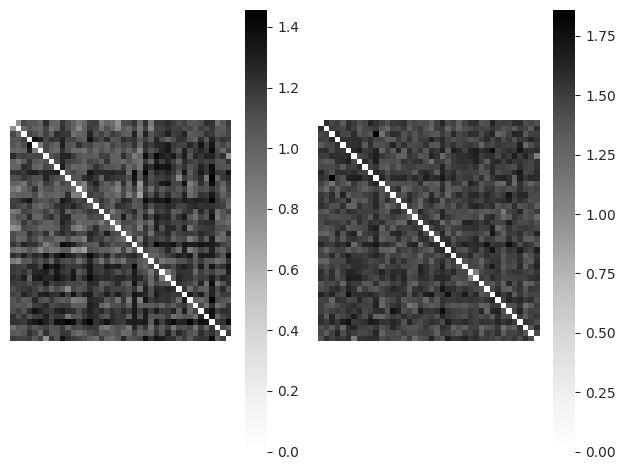

In [46]:
similarity_dict = compute_40_image_rdm_similarity(results, cat_activations, ['saycam', 'ego'], labels[:10])

In [49]:

def sample_rdm_pairs_memory_efficient(RDM1, RDM2, n_samples=100000, subset_size=40,
                                    batch_size=10000, seed=None):
    """
    Memory-efficient version that processes in batches and optionally saves to disk.

    Parameters:
    -----------
    batch_size : int
        Number of samples to process at once (default: 1000)
    output_file : str, optional
        If provided, saves results to this file using pickle
    """

    if seed is not None:
        np.random.seed(seed)

    n_images = RDM1.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size

    all_sims_samples = []
    all_indices = []

    print(f"Processing {n_samples} samples in {n_batches} batches of {batch_size}...")

    for batch_idx in tqdm_notebook(range(n_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_samples)
        current_batch_size = end_idx - start_idx

        # Allocate batch arrays
        batch_sim = np.zeros((current_batch_size))
        batch_indices = np.zeros((current_batch_size, subset_size), dtype=int)

        for i in range(current_batch_size):
            # Randomly select images
            indices = np.random.choice(n_images, size=subset_size, replace=False)
            indices = np.sort(indices)

            # Extract submatrices
            batch_sim[i] = rsa.Compute_sim_RDMs(RDM1[np.ix_(indices, indices)], RDM2[np.ix_(indices, indices)], center = False, metric = 'pearson')
            batch_indices[i] = indices

        all_sims_samples.append(batch_sim)
        all_indices.append(batch_indices)

    # Concatenate all batches
    sim_samples = np.concatenate(all_sims_samples, axis=0)
    indices_used = np.concatenate(all_indices, axis=0)


    return sim_samples, indices_used

sim_samples, indices_used = sample_rdm_pairs_memory_efficient(RDMs['saycam'], RDMs['ego'], n_samples=100000, subset_size=40,
                                    batch_size=1000, seed=None)

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

We obtain 2 40*40 RDMs with a similarity significantly lower than the average similarity over the full set of images.

Let's see now if the resulting mini RDMs are also significantly lower than the majority of subset we could have chosen (estimate over 1000000 images).

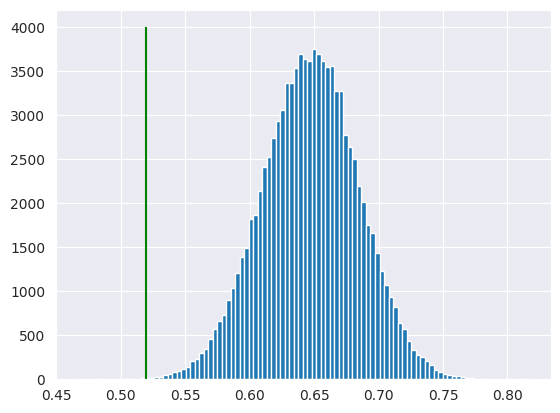

In [51]:
plt.hist(sim_samples, 100)
plt.vlines(similarity_dict['similarity'], 0, 4000, 'green')
plt.show()
perc = np.sum(sim_samples< similarity_dict['similarity'])/len(sim_samples)

In [53]:
perc

np.float64(0.0005)